In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.rcParams['figure.figsize'] = (12,5)

path = "../processed/traffic_master.csv"

if not os.path.exists(path):
    print("Processed file not found. Falling back to raw API dataset.")
    path = "../data/traffic_timeseries.csv"

df = pd.read_csv(path)

df.head()


,timestamp,city,location,traffic_volume,avg_speed,travel_time_index,congestion_level,road_capacity_utilization,incident_reports,environmental_impact,...,pedestrian_cyclist_count,weather_conditions,roadwork_activity,latitude,longitude,free_flow_speed,current_travel_time,free_flow_travel_time,confidence,road_closure
0,2022-01-01,Indiranagar,100 Feet Road,50590.0,50.230299,1.500000,100.000000,100.000000,0.0,151.180,...,111.0,Clear,No,23.07205,75.95555,24.0,528.5,370.5,0.910647,False
1,2022-01-01,Indiranagar,CMH Road,30825.0,29.377125,1.500000,100.000000,100.000000,1.0,111.650,...,100.0,Clear,No,23.07205,75.95555,24.0,528.5,370.5,0.910647,False
2,2022-01-01,Whitefield,Marathahalli Bridge,7399.0,54.474398,1.039069,28.347994,36.396525,0.0,64.798,...,189.0,Clear,No,23.07205,75.95555,24.0,528.5,370.5,0.910647,False
3,2022-01-01,Koramangala,Sony World Junction,60874.0,43.817610,1.500000,100.000000,100.000000,1.0,171.748,...,111.0,Clear,No,23.07205,75.95555,24.0,528.5,370.5,0.910647,False
4,2022-01-01,Koramangala,Sarjapur Road,57292.0,41.116763,1.500000,100.000000,100.000000,3.0,164.584,...,104.0,Clear,No,23.07205,75.95555,24.0,528.5,370.5,0.910647,False


In [3]:
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

print("\nData Types:")
print(df.dtypes)

# Find timestamp column
ts_cols = [c for c in df.columns if "time" in c.lower()]
print("\nTimestamp-like columns:", ts_cols)

if ts_cols:
    ts_col = ts_cols[0]
    df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
    print(f"Using timestamp column: {ts_col}")
else:
    raise ValueError("No timestamp column detected!")

print("\nMissing values:")
print(df.isnull().sum().sort_values(ascending=False).head(15))

# remove duplicates
dupes = df.duplicated().sum()
df = df.drop_duplicates().reset_index(drop=True)
print("\nDuplicates removed:", dupes)


Shape: (8976, 23)

Columns: ['timestamp', 'city', 'location', 'traffic_volume', 'avg_speed', 'travel_time_index', 'congestion_level', 'road_capacity_utilization', 'incident_reports', 'environmental_impact', 'public_transport_usage', 'traffic_signal_compliance', 'parking_usage', 'pedestrian_cyclist_count', 'weather_conditions', 'roadwork_activity', 'latitude', 'longitude', 'free_flow_speed', 'current_travel_time', 'free_flow_travel_time', 'confidence', 'road_closure']

Data Types:
timestamp                     object
city                          object
location                      object
traffic_volume               float64
avg_speed                    float64
travel_time_index            float64
congestion_level             float64
road_capacity_utilization    float64
incident_reports             float64
environmental_impact         float64
public_transport_usage       float64
traffic_signal_compliance    float64
parking_usage                float64
pedestrian_cyclist_count     float

In [4]:
# Possible columns from combined merge
volume_cols = [c for c in df.columns if "volume" in c.lower()]
speed_cols  = [c for c in df.columns if "speed" in c.lower()]
cong_cols   = [c for c in df.columns if "congest" in c.lower()]
travel_cols = [c for c in df.columns if "travel" in c.lower()]

print("Volume columns:", volume_cols)
print("Speed columns:", speed_cols)
print("Congestion columns:", cong_cols)
print("Travel time columns:", travel_cols)


Volume columns: ['traffic_volume']
Speed columns: ['avg_speed', 'free_flow_speed']
Congestion columns: ['congestion_level']
Travel time columns: ['travel_time_index', 'current_travel_time', 'free_flow_travel_time']


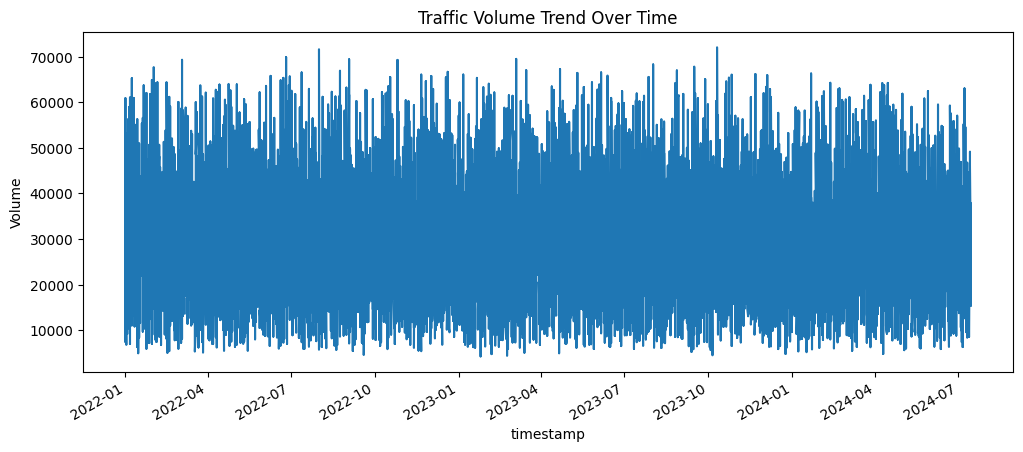

In [5]:
if volume_cols:
    df_sorted = df.sort_values(ts_col)
    df_sorted.set_index(ts_col)[volume_cols[0]].plot(
        title="Traffic Volume Trend Over Time"
    )
    plt.ylabel("Volume")
    plt.show()
else:
    print("No traffic volume column found.")


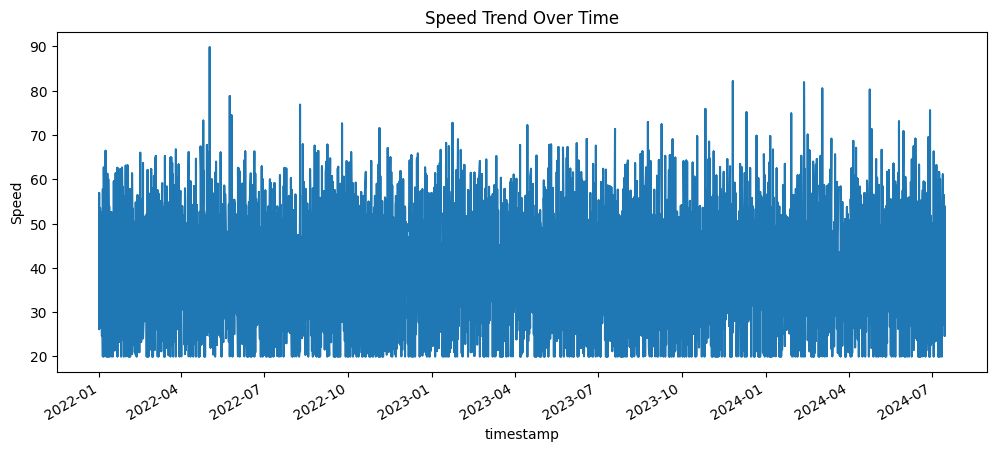

In [6]:
if speed_cols:
    df_sorted.set_index(ts_col)[speed_cols[0]].plot(
        title="Speed Trend Over Time"
    )
    plt.ylabel("Speed")
    plt.show()
else:
    print("No speed column found.")


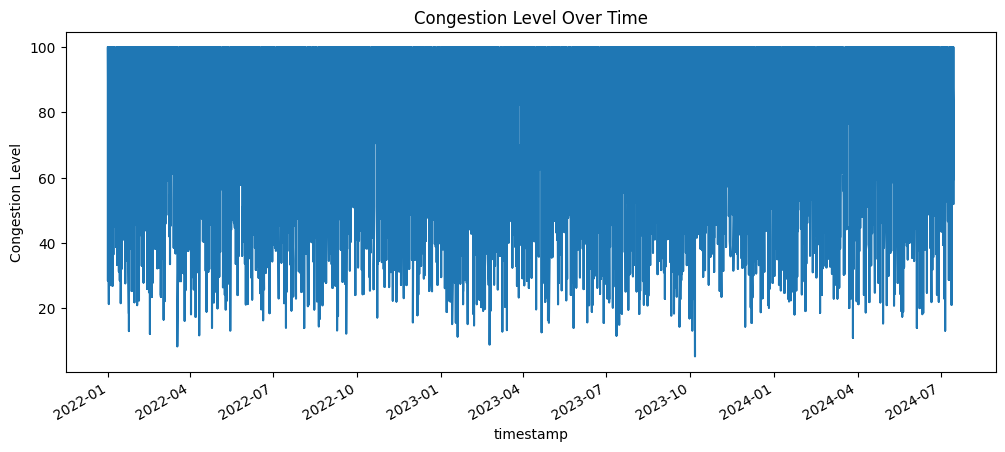

In [7]:
if cong_cols:
    df_sorted.set_index(ts_col)[cong_cols[0]].plot(
        title="Congestion Level Over Time"
    )
    plt.ylabel("Congestion Level")
    plt.show()
else:
    print("No congestion column found.")


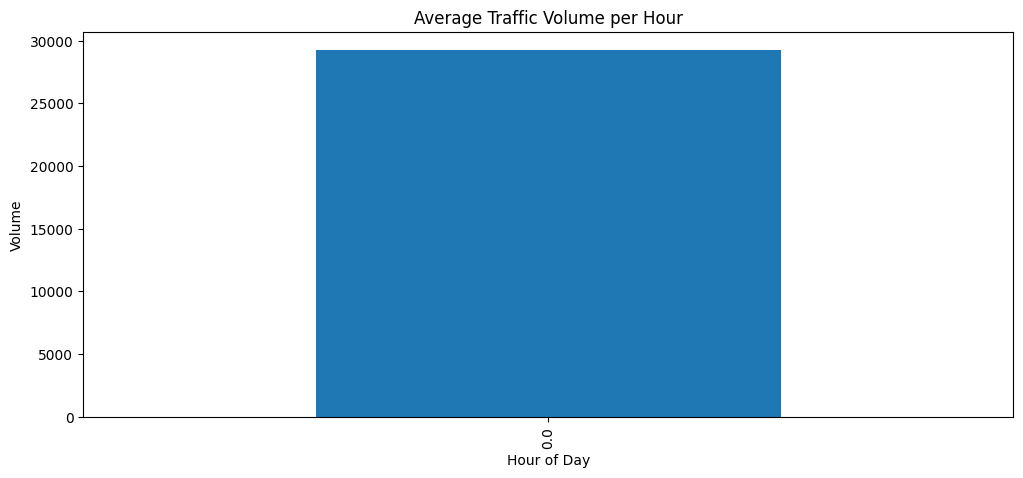

In [8]:
df['hour'] = df[ts_col].dt.hour

if volume_cols:
    df.groupby('hour')[volume_cols[0]].mean().plot(kind='bar', figsize=(12,5))
    plt.title("Average Traffic Volume per Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("Volume")
    plt.show()
else:
    print("No volume column for hourly analysis.")


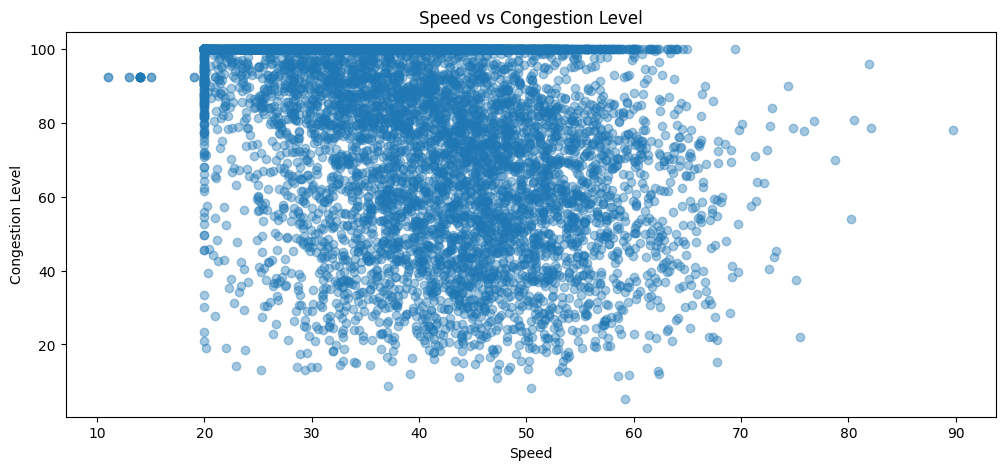

In [9]:
if speed_cols and cong_cols:
    plt.scatter(df[speed_cols[0]], df[cong_cols[0]], alpha=0.4)
    plt.title("Speed vs Congestion Level")
    plt.xlabel("Speed")
    plt.ylabel("Congestion Level")
    plt.show()
else:
    print("Need both speed and congestion columns for this plot.")


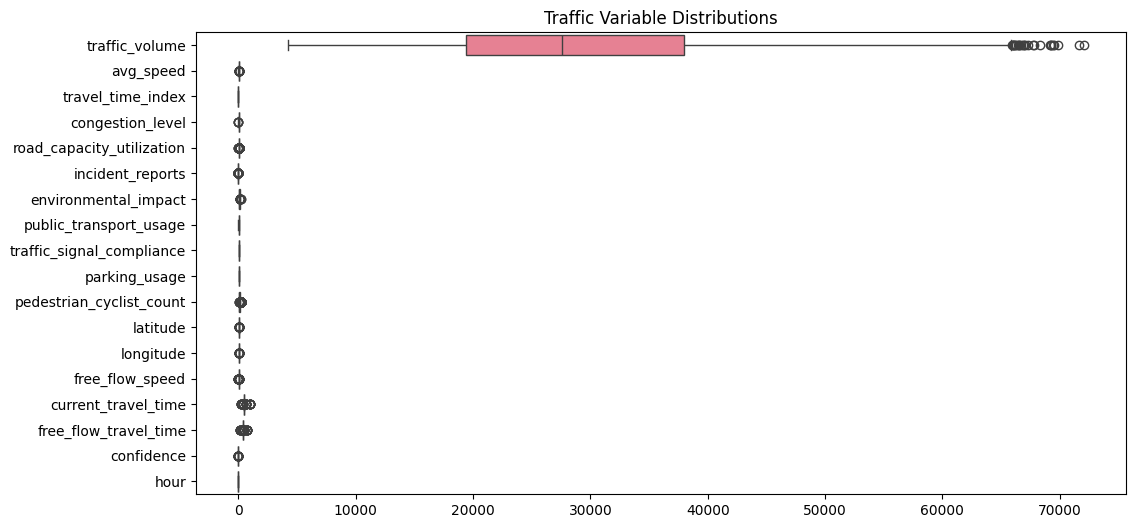

In [10]:
num_cols = df.select_dtypes(include=['number']).columns.tolist()

plt.figure(figsize=(12,6))
sns.boxplot(data=df[num_cols], orient='h')
plt.title("Traffic Variable Distributions")
plt.show()


In [11]:
df['date'] = df[ts_col].dt.date

daily_traffic = df.groupby('date')[num_cols].median().reset_index()

os.makedirs("../results", exist_ok=True)
daily_traffic.to_csv("../results/traffic_daily_median.csv", index=False)

print("Saved → ../results/traffic_daily_median.csv")


Saved → ../results/traffic_daily_median.csv
